<a href="https://colab.research.google.com/github/YEN-PO-CHEN/Colab/blob/main/DIP_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.3)


# Loading data

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from os import listdir
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print("Use device:",device)

Use device: cuda:0


In [ ]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/專題/Segmentation Fault/data'
Train_DIR = os.path.join(DATA_DIR, 'train')
Test_DIR = os.path.join(DATA_DIR, 'test')

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Train Data

In [ ]:
CT = []
FT = []
MN = []
T1 = []
T2 = []
for idx in range(0,9):
  data = Train_DIR + "/{}/".format(idx)
  CT = CT + [data+"CT/"+ f for f in listdir(os.path.join(data,"CT"))]
  FT = FT + [data+"FT/"+ f for f in listdir(os.path.join(data,"FT"))]
  MN = MN + [data+"MN/"+ f for f in listdir(os.path.join(data,"MN"))]
  T1 = T1 + [data+"T1/"+ f for f in listdir(os.path.join(data,"T1"))]
  T2 = T2 + [data+"T2/"+ f for f in listdir(os.path.join(data,"T2"))]

## Test Data

In [ ]:
Test_CT = []
Test_FT = []
Test_MN = []
Test_T1 = []
Test_T2 = []
for idx in range(9,10):
  data = Test_DIR + "/{}/".format(idx)
  Test_CT = Test_CT + [data+"CT/"+ f for f in listdir(os.path.join(data,"CT"))]
  Test_FT = Test_FT + [data+"FT/"+ f for f in listdir(os.path.join(data,"FT"))]
  Test_MN = Test_MN + [data+"MN/"+ f for f in listdir(os.path.join(data,"MN"))]
  Test_T1 = Test_T1 + [data+"T1/"+ f for f in listdir(os.path.join(data,"T1"))]
  Test_T2 = Test_T2 + [data+"T2/"+ f for f in listdir(os.path.join(data,"T2"))]

# Data Loader

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """
    Args:
        image_path (dir): path to image(T1, T2)
        masks_path (dir): path to masks(CT, FT, MN)
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    """
    
    def __init__(
            self,
            image_path,
            masks_path,
            augmentation=None,
            preprocessing=None,
    ):
        self.T1 = image_path['T1']
        self.T2 = image_path['T2']
        self.CT = masks_path['CT']
        self.FT = masks_path['FT']
        self.MN = masks_path['MN']
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        
        # read data
        T1 = cv2.imread(self.T1[idx], cv2.IMREAD_GRAYSCALE)
        T2 = cv2.imread(self.T2[idx], cv2.IMREAD_GRAYSCALE)
        CT = cv2.imread(self.CT[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        FT = cv2.imread(self.FT[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        MN = cv2.imread(self.MN[idx], cv2.IMREAD_GRAYSCALE).astype('float')
        zero = np.zeros((T1.shape[0],T1.shape[1]),dtype=np.uint8)
        image = np.stack((T1, T2, zero),axis = 2)
        mask = np.stack((CT, FT, MN),axis = 2)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image/255, mask/255
        
    def __len__(self):
        return len(self.image)

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.OneOf([albu.CLAHE(p=1),
              albu.RandomBrightness(p=1),
              albu.RandomGamma(p=1),
            ],p=0.9,),
        albu.OneOf([albu.IAASharpen(p=1),
              albu.Blur(blur_limit=3, p=1),
              albu.MotionBlur(blur_limit=3, p=1),
            ],p=0.9,),
        albu.OneOf([albu.RandomContrast(p=1),
              albu.HueSaturationValue(p=1),
            ],p=0.9,),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albument

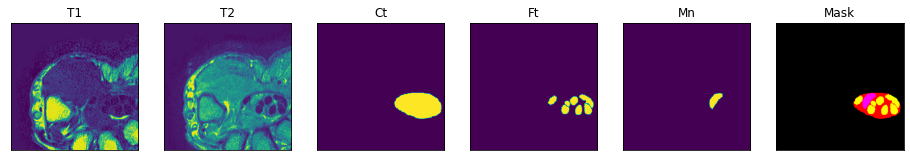

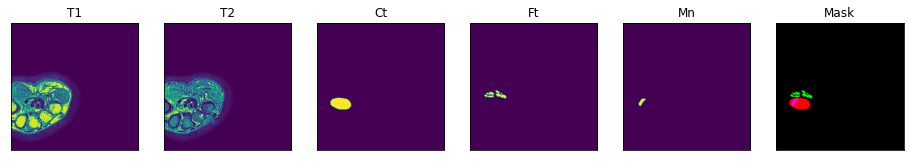

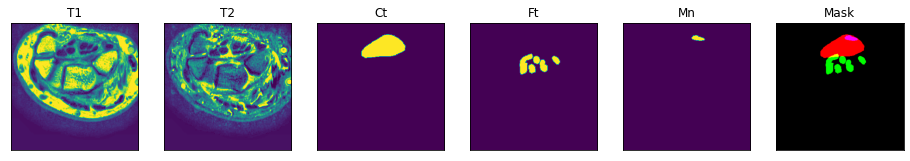

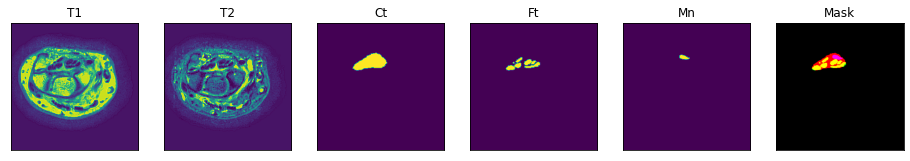

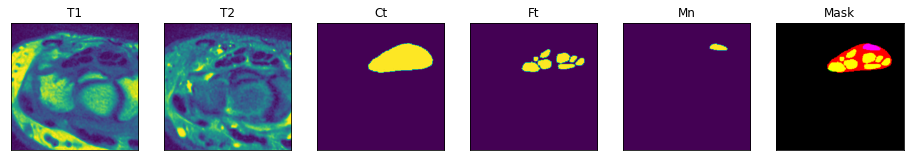

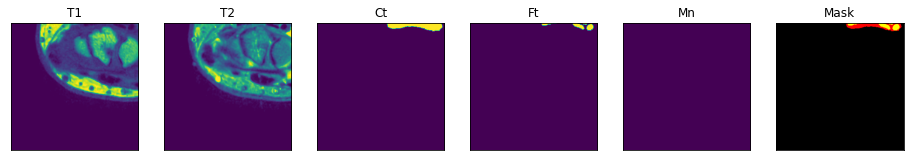

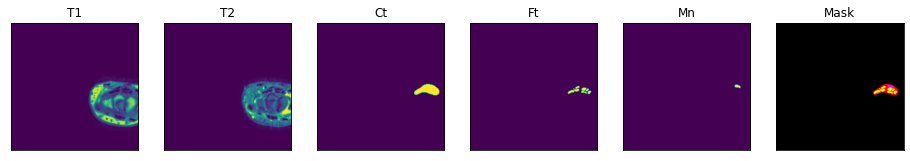

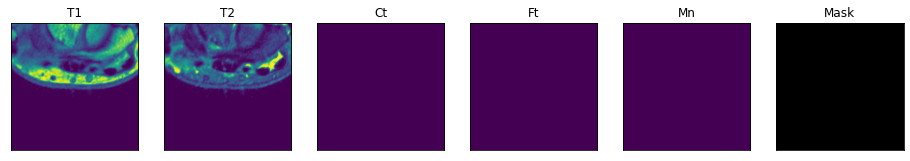

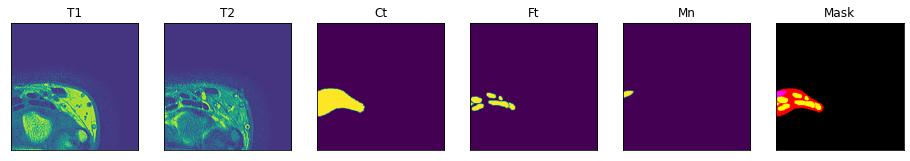

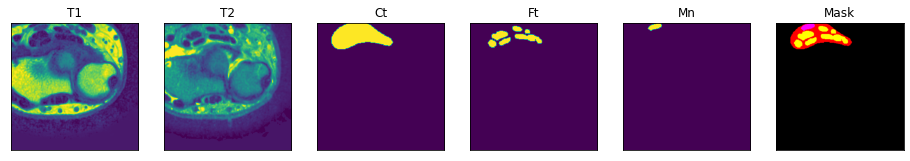

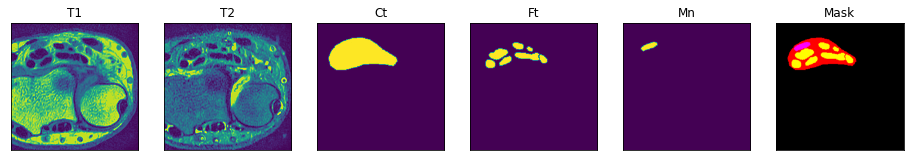

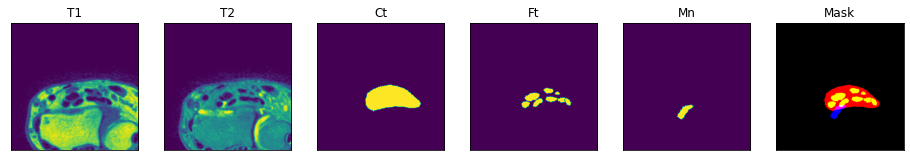

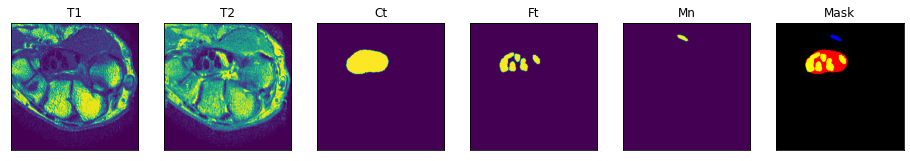

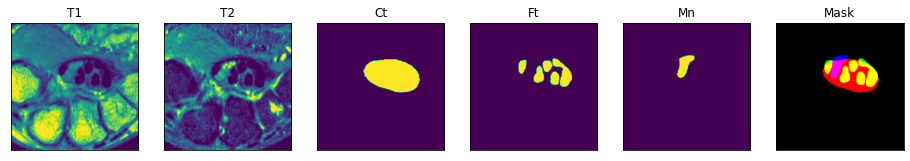

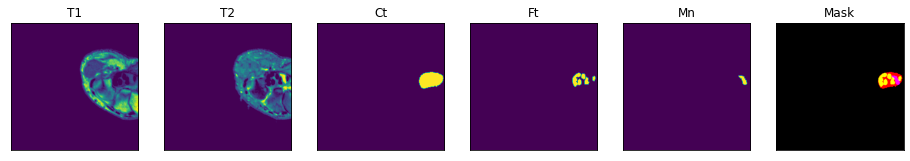

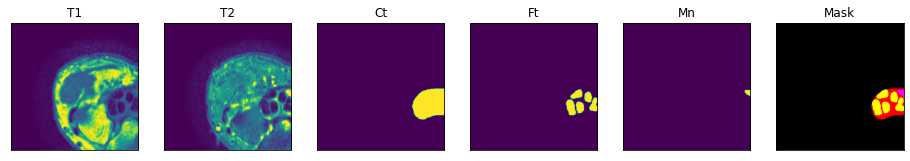

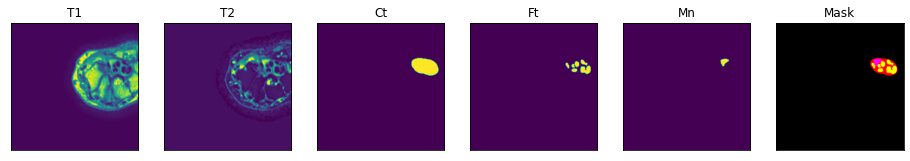

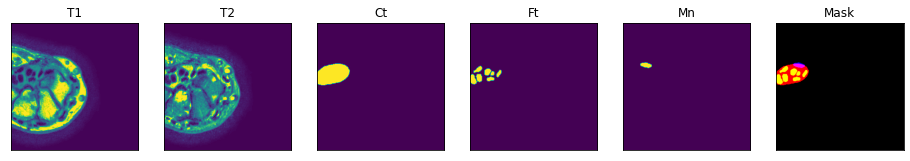

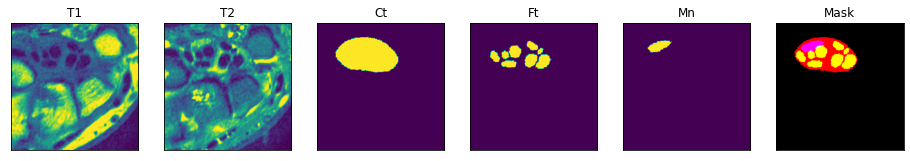

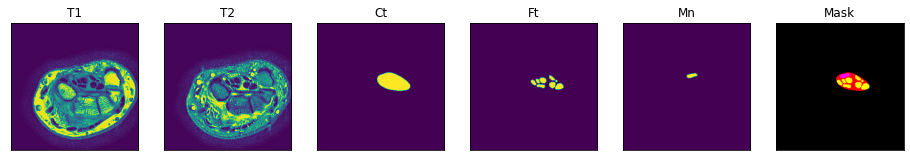

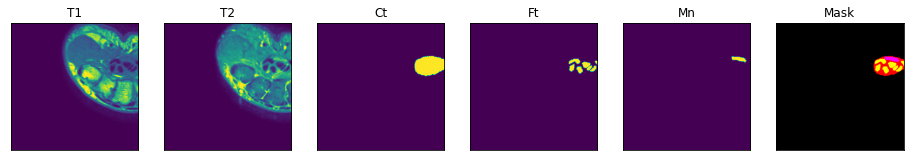

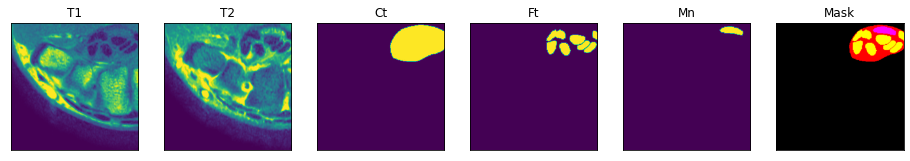

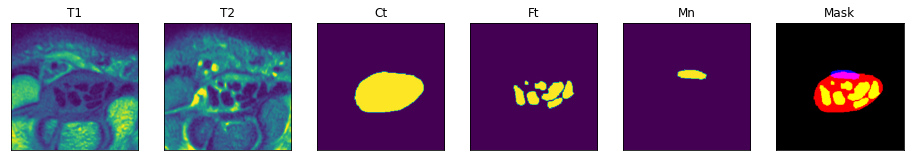

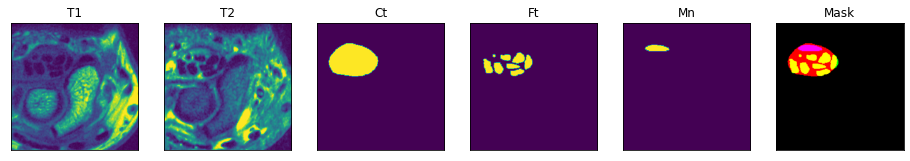

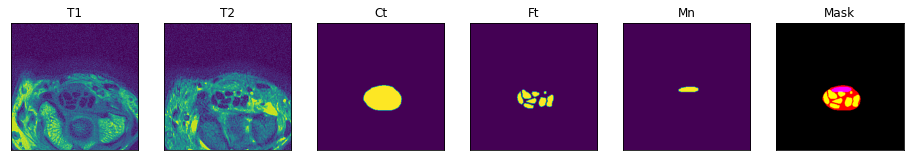

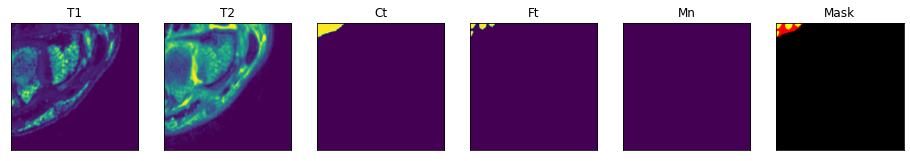

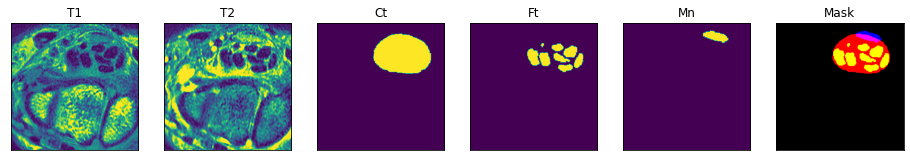

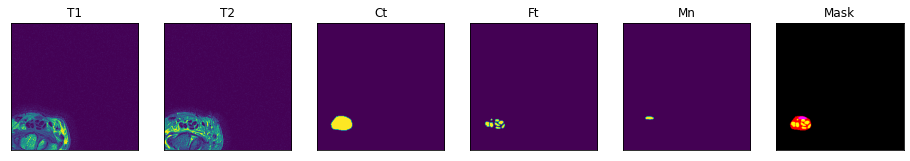

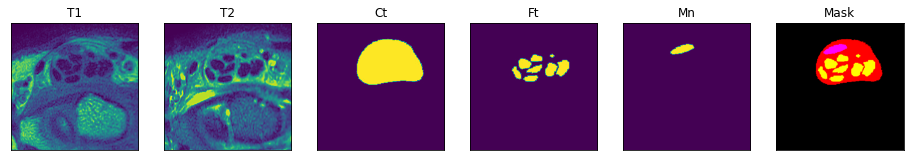

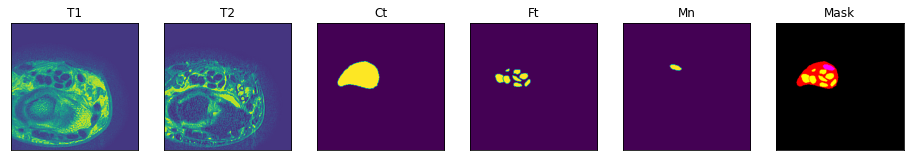

In [ ]:
TrainSet = Dataset(image_path = {"T1":T1, "T2":T2},
          masks_path = {"CT":CT, "FT":FT, "MN":MN},
          augmentation=get_training_augmentation(),
          preprocessing=None,
          )
TestSet = Dataset(image_path = {"T1":Test_T1, "T2":Test_T2},
          masks_path = {"CT":Test_CT, "FT":Test_FT, "MN":Test_MN},
          augmentation=get_validation_augmentation(),
          preprocessing=None,
          )
for i in range(0,30):
  image, mask = TrainSet[i] # get some sample
  visualize(
    T1 = image[:,:,0],
    T2 = image[:,:,1],
    CT = mask[:,:,0].squeeze(),
    FT = mask[:,:,1].squeeze(),
    MN = mask[:,:,2].squeeze(),
    mask = mask
  )

# K-fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5,shuffle=False)
for train_index , test_index in kf.split(X):
   print('train_index:%s , test_index: %s ' %(train_index,test_index))